<a href="https://colab.research.google.com/github/TRoYals/My_Algo_Lib/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM预测ETH价格

## 包导入

In [ ]:
import numpy as np 
import pandas as pd 


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip instll matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler


## 数据导入和初步处理


In [ ]:
csv_path = "https://raw.githubusercontent.com/TRoYals/LSTM_ETH/master/data/eth-usd-max.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
data = pd.read_csv(csv_path, parse_dates=['snapped_at'])
data = data.sort_values('snapped_at')
data.head()

,snapped_at,price,market_cap,total_volume
0,2015-08-07 00:00:00+00:00,2.831620,0.000000e+00,9.062200e+04
1,2015-08-08 00:00:00+00:00,1.330750,8.033948e+07,3.680700e+05
2,2015-08-10 00:00:00+00:00,0.687586,4.155631e+07,4.004641e+05
3,2015-08-11 00:00:00+00:00,1.067379,6.453901e+07,1.518998e+06
4,2015-08-12 00:00:00+00:00,1.256613,7.601326e+07,2.073893e+06


In [ ]:
data= data.rename(columns={"snapped_at":"Date","market_cap":"market","total_volume":"volume"})

In [ ]:
# 考虑到训练效果，只取后2k天的数据
data=data[1000:3000]

In [ ]:
data.reset_index(drop=True, inplace=True)
data["Date"] = data["Date"].astype(str).str[:10]

In [ ]:
data.shape

(1802, 4)

In [ ]:
data.head()

,Date,price,market,volume
0,2018-05-04,781.425780,7.752658e+10,1.005515e+09
1,2018-05-05,777.907647,7.719438e+10,1.967183e+09
2,2018-05-06,807.067329,8.010468e+10,1.617672e+09
3,2018-05-07,785.892744,7.801932e+10,1.742487e+09
4,2018-05-08,748.813141,7.435370e+10,2.808728e+09


### ETH走势图——基本图


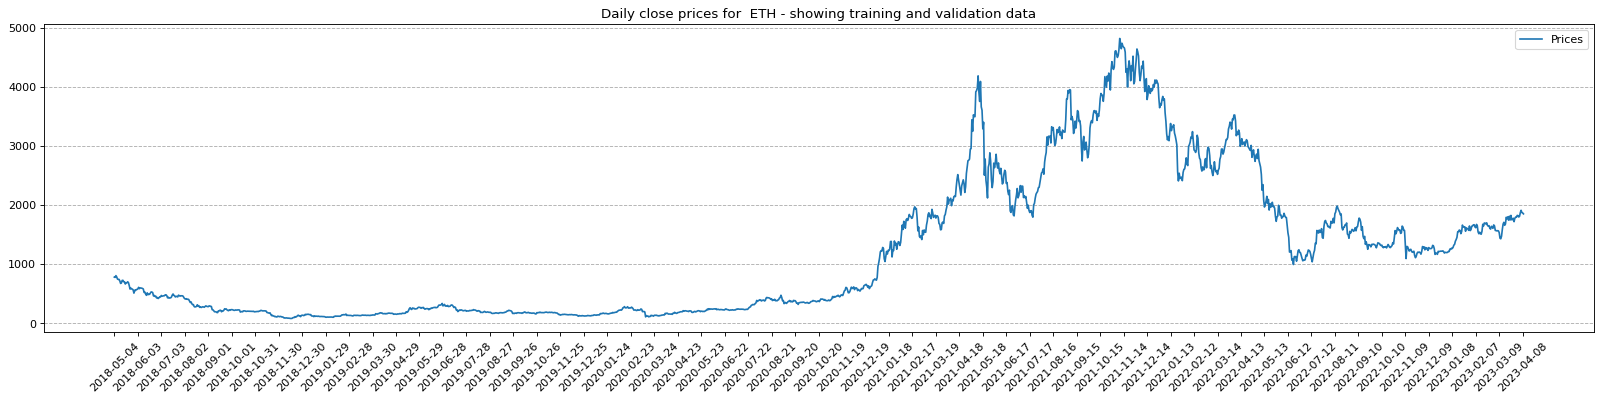

In [ ]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data[['price']], label="Prices")
plt.xticks(range(0,data.shape[0],30), data['Date'].loc[::30], rotation=45)

plt.title("Daily close prices for  "+"ETH - showing training and validation data")
plt.grid( which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 特征工程
数据归一化处理


In [ ]:
price = data[['price', 'volume',"market"]]
price

,price,volume,market
0,781.425780,1.005515e+09,7.752658e+10
1,777.907647,1.967183e+09,7.719438e+10
2,807.067329,1.617672e+09,8.010468e+10
3,785.892744,1.742487e+09,7.801932e+10
4,748.813141,2.808728e+09,7.435370e+10
...,...,...,...
1797,1871.333526,1.158051e+10,2.252579e+11
1798,1911.338690,1.158648e+10,2.303701e+11
1799,1872.246682,9.208409e+09,2.255496e+11
1800,1866.657545,9.298216e+09,2.248847e+11


In [ ]:
scaler1 = MinMaxScaler(feature_range=(-1, 1))
price['price'] = scaler1.fit_transform(price['price'].values.reshape(-1,1))


<ipython-input-14-6d7426eb883f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['price'] = scaler1.fit_transform(price['price'].values.reshape(-1,1))


In [ ]:
scaler2 = MinMaxScaler(feature_range=(-1, 1))


In [ ]:
price['volume'] = scaler2.fit_transform(price['volume'].values.reshape(-1,1))
scaler3 = MinMaxScaler(feature_range=(-1, 1))

price['market'] = scaler3.fit_transform(price['market'].values.reshape(-1,1))


<ipython-input-16-497033f4a213>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['volume'] = scaler2.fit_transform(price['volume'].values.reshape(-1,1))
<ipython-input-16-497033f4a213>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['market'] = scaler3.fit_transform(price['market'].values.reshape(-1,1))


In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1802 non-null   float64
 1   volume  1802 non-null   float64
 2   market  1802 non-null   float64
dtypes: float64(3)
memory usage: 42.4 KB


#  LSTM

## 数据集制作


In [ ]:
price

,price,volume,market
0,-0.705091,-0.995289,-0.755476
1,-0.706578,-0.981573,-0.756656
2,-0.694252,-0.986558,-0.746317
3,-0.703203,-0.984778,-0.753726
4,-0.718877,-0.969571,-0.766748
...,...,...,...
1797,-0.244361,-0.844467,-0.230647
1798,-0.227449,-0.844382,-0.212485
1799,-0.243975,-0.878298,-0.229610
1800,-0.246337,-0.877017,-0.231972


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 30
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1418, 29, 3)
y_train.shape =  (1418, 3)
x_test.shape =  (354, 29, 3)
y_test.shape =  (354, 3)


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [ ]:

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
y_temp=y_train

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
input_dim = 3
hidden_dim = 100
num_layers = 3
output_dim = 1
num_epochs = 300
dropout_prob = 0.00

### rest


In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
y_train_scaler1 = y_temp[:,[0]]

In [ ]:
y_train_scaler1.shape

torch.Size([1418, 1])

In [ ]:
y_train_pred.shape

torch.Size([1418, 1])

In [ ]:
y_train_pred = pd.DataFrame(scaler1.inverse_transform(y_train_pred.detach().numpy()))
y_train = pd.DataFrame(scaler1.inverse_transform(y_train_scaler1.detach().numpy()))

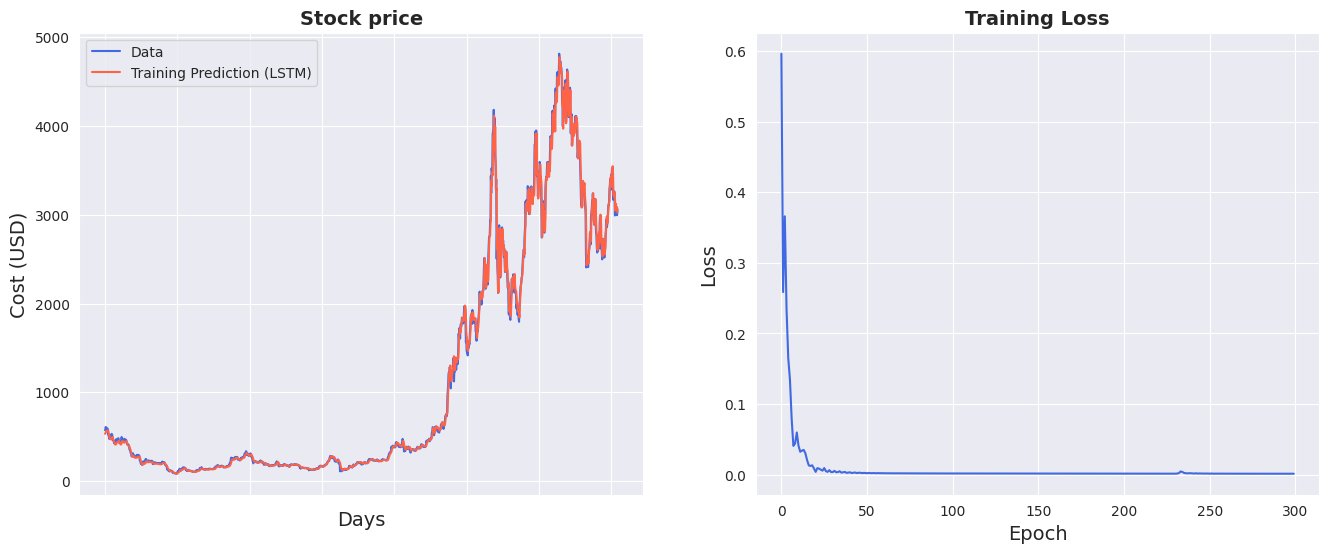

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = y_train.index, y = y_train[0], label="Data", color='royalblue')
ax = sns.lineplot(x = y_train_pred.index, y = y_train_pred[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)


In [ ]:
y_test_pred_scaler1 = model(x_test)

In [ ]:
y_test_scaler1 = y_test[:,[0]]

In [ ]:
y_test_pred = pd.DataFrame(scaler1.inverse_transform(y_test_pred.detach().numpy()))
y_test = pd.DataFrame(scaler1.inverse_transform(y_test_scaler1.detach().numpy()))

In [ ]:
y_test = scaler1.inverse_transform(y_test_scaler1.detach().numpy())

In [ ]:
mseLSTMTest = np.mean(np.square(y_test - y_test_pred))

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



In [ ]:
mseLSTMTest

0    9388.84375
dtype: float32

In [ ]:
mseLSTMTrain = np.mean(np.square(y_train_pred- y_train))

In [ ]:
mseLSTMTrain

0    6940.559082
dtype: float32

In [ ]:
dataset = np.concatenate((y_test , y_test_pred), axis=1)


In [ ]:
dataset.shape

(354, 2)

在使用 LSTM 模型进行时间序列预测时，通常需要将训练数据集和测试数据集进行拆分，并使用训练数据集训练 LSTM 模型。在使用 LSTM 模型预测测试数据集时，可以使用训练数据集中的最后一个时间步长的预测结果作为第一个测试数据点的预测值，然后使用 LSTM 模型预测下一个测试数据点。这种方式称为“滚动预测”（rolling prediction）。

In [ ]:
y_train_pred.shape

(1418, 1)

In [ ]:
original = scaler1.inverse_transform(price['price'].values.reshape(-1,1))


In [ ]:
y_train.shape

(1418, 1)

In [ ]:
trainPredictPlot = np.empty((len(price), 1))
trainPredictPlot[:] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

testPredictPlot = np.empty((len(price), 1))
testPredictPlot[:] = np.nan

testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred
original = scaler1.inverse_transform(price['price'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()